In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import imgaug

import sys
sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Microtubule")
data_dir = root_dir / "Data"
log_dir = root_dir / "Logs"
saved_model_dir = root_dir / "SavedModel"

# Import the configuration associated with this dataset and network.
config = maskflow.load_config(root_dir / "config.yml")

Using TensorFlow backend.


# Load Training Dataset

In [2]:
# Split dataset
fnames = list((data_dir / "Image").glob("*.tif"))
#fnames = np.random.choice(fnames, 50)
train_fnames, validation_fnames = train_test_split(fnames, test_size=0.3)

# Build dataset
dataset_train = maskflow.MaskflowDataset()
dataset_train.set_dataset(train_fnames, config["CLASS_NAMES"])

dataset_val = maskflow.MaskflowDataset()
dataset_val.set_dataset(validation_fnames, config["CLASS_NAMES"])

print(f"train_fnames : {len(train_fnames)} | validation_fnames : {len(validation_fnames)}")

train_fnames : 34 | validation_fnames : 15


{'id': 32, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/preprocessed s4ch2 10uM hilyte 488 1 to 16 label ratio 10s-FLAT-T-105-C-1_AUGMENTED_0.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/preprocessed s4ch2 10uM hilyte 488 1 to 16 label ratio 10s-FLAT-T-105-C-1_AUGMENTED_0.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/preprocessed s4ch2 10uM hilyte 488 1 to 16 label ratio 10s-FLAT-T-105-C-1_AUGMENTED_0.csv')}


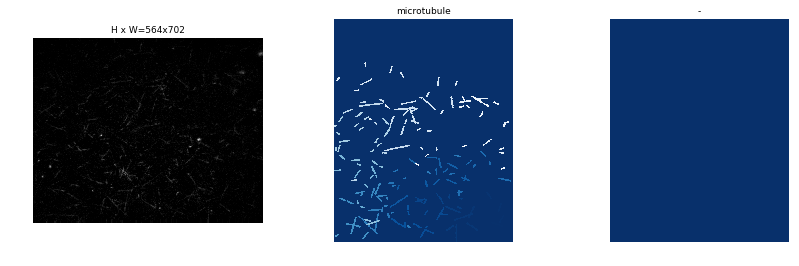

{'id': 25, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/preprocessed s4ch2 10uM hilyte 488 1 to 16 label ratio 10s-FLAT-T-105-C-1.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/preprocessed s4ch2 10uM hilyte 488 1 to 16 label ratio 10s-FLAT-T-105-C-1.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/preprocessed s4ch2 10uM hilyte 488 1 to 16 label ratio 10s-FLAT-T-105-C-1.csv')}


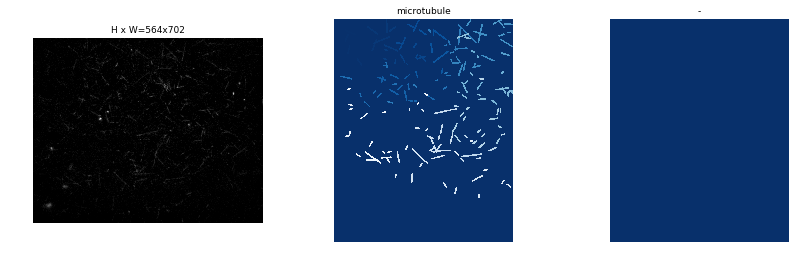

In [3]:
dataset_train.random_display(n=2, n_class=2)

# Training

In [4]:
maskflow_config = maskflow.MaskflowConfig(config)

maskflow_config.IMAGES_PER_GPU = 1
maskflow_config.GPU_COUNT = 1
maskflow_config.STEPS_PER_EPOCH = 200

maskflow_config.update()
maskflow_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1, 0.1, 0.2, 0.2]
CLASS_NAMES                    ['microtubule']
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  100
IMAGE_MIN_SCALE                1
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SH

In [6]:
model = maskflow.load_model(log_dir, maskflow_config, mode="training")

maskflow.load_weights(model, init_with="coco")

# Copy config file to log directory
maskflow.save_config(config, Path(model.log_dir) / "config.yml")

ValueError: Dimension 3 in both shapes must be equal, but are 14 and 6. Shapes are [1,1,512,14] and [1,1,512,6]. for 'Assign_673' (op: 'Assign') with input shapes: [1,1,512,14], [1,1,512,6].

In [ ]:
augmentation = imgaug.augmenters.Sometimes(0.5, [
               imgaug.augmenters.Fliplr(0.5)])

model.train(dataset_train, dataset_val, learning_rate=maskflow_config.LEARNING_RATE,
            epochs=50, layers='heads', augmentation=augmentation)

In [ ]:
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE,
            epochs=200, layers='all', augmentation=augmentation)

# Load Trained Model

In [4]:
training_name = "shapes_detector20180621T0950"

maskflow_config = maskflow.MaskflowConfig(config)
maskflow_config.IMAGES_PER_GPU = 1
maskflow_config.GPU_COUNT = 1
maskflow_config.update()

model = maskflow.load_model(log_dir, maskflow_config, mode="inference")
maskflow.load_weights(model, init_with=training_name)

# Load image with true predictions

{'id': 99, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Shapes/Data/Image/toy_0305.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Shapes/Data/Mask/toy_0305.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Shapes/Data/Class/toy_0305.csv')}


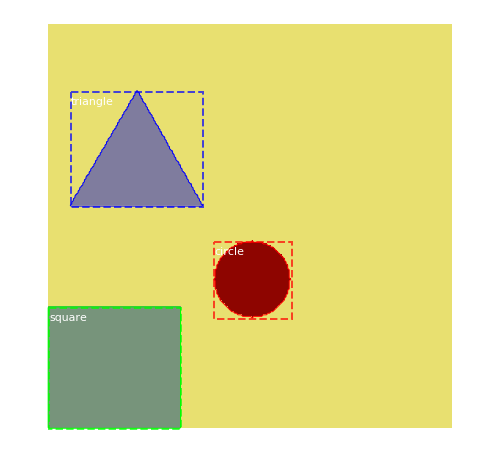

In [12]:
# Load a random image
image_id = np.random.choice(dataset_val.image_ids)
#image_id = 99

print(dataset_val.image_info[image_id])
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = maskflow.load_image_gt(dataset_val,
                                                                                   maskflow_config,
                                                                                   image_id,
                                                                                   use_mini_mask=False)

maskflow.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))

# Predict

In [13]:
results = maskflow.predict(original_image, model, progress=True, verbose=0)

masked_images = maskflow.draw_results(original_image, results, model.config.CLASS_NAMES, colors=None, resize_ratio=1, draw_boxes=True, draw_masks=True, draw_contours=True, draw_score=True)
maskflow.show_images([[original_image], masked_images], size=10)

100%|██████████| 1/1 [00:00<00:00, 129.95it/s]


interactive(children=(IntSlider(value=0, description='t', max=0), Output()), _dom_classes=('widget-interact',)…

# Export trained model to ZIP

In [ ]:
model_name = "good_one"
maskflow.export_to_zip(model, model_name, saved_model_dir)